# **Succesful Film Genres**
By Jonathan Nunez

## Business Understanding
The company is looking into expanding into the box office market. The company sees the potential income in creating their own original video content through the use of their own new movie studio. I was tasked with exploring what types of films are currently doing the best at the box office. As the company is looking for the genre(s) that are doing the best, I plan to narrow this down by finding which genre(s) yields the highest return on investment on average.

## Data Understanding
The data being used to fulfill this task is the [IMDB](https://www.imdb.com/) movie database, [Box Office Mojo](https://www.boxofficemojo.com/), and [The Numbers](https://www.the-numbers.com/) datasets. The data in The Numbers contains movie records ranging as early as 1920 up to 2019, while the IMBD, and the Box Office Mojo data is more focused between 2010 through 2019. Among the three datasets, you can find information such the genre or genres the listed film falls under, the date the film was released, both domestic and foreign gross, to even the production budget of the film.

In [1]:
# Importing necessary tools
import pandas as pd
import numpy as np
import sqlite3

In [2]:
# Connecting to the IMDB film database
path = 'data/im.db'
conn = sqlite3.connect(path)

im_db = pd.read_sql("""
                    SELECT *
                      FROM sqlite_master
                    """
                    , conn
                   )

In [3]:
# Importing CSV files used for The Numbers and Box Office Mojo
bom_df = pd.read_csv('data/bom.movie_gross.csv.gz')
the_num_df = pd.read_csv('data/tn.movie_budgets.csv.gz')

In [4]:
# Writing a quarry to contain the data needed for the project and assigning it to a variable
q = """
    SELECT primary_title AS 'title', 
           start_year AS 'release_yr', 
           genres, 
           averagerating AS 'avg_rating'
      FROM movie_basics
      JOIN movie_ratings
           USING(movie_id)
     ORDER BY primary_title;
    """
imdb_df = pd.read_sql(q, conn)

## Data Preparation
For data preparation, I first replace column names for both The Numbers, and the Box Office Mojo dataframes to make all column names in the datasets being used as uniform as possible, this will also make it easier to combine the datasets. From there I looked through the data with shared column names and made sure the data itself was uniform and of the proper data type.

In [5]:
# Changing column names to be uniform with other datasets
the_num_df.columns = the_num_df.columns.str.replace('movie', 'title')
the_num_df.columns = the_num_df.columns.str.replace('worldwide_gross', 'foreign_gross')
the_num_df.columns = the_num_df.columns.str.replace('release_date', 'release_yr')

In [6]:
bom_df.columns = bom_df.columns.str.replace('year', 'release_yr')

In [7]:
# Removing month and day from date for uniformity with other datasets 
the_num_df['release_yr'] = the_num_df['release_yr'].str.split(',').str[1]

Both the Box Office Mojo, and The Numbers dataframes contain domestic and foreign gross columns, but they either contain a currency symbol or the data type is formatted as a non-numerical dtype. I created a function that will take in a dataframe as well as a column name or list of columns containing numerical values, and it will remove all symbols as well as white spaces in the values, and then convert the result into an integer data type. If the data type of the column is a different numerical type other than integer, it will simply convert the data type into integer.

In [8]:
# Function to remove symbols from values and convert specified Object dtypes with numeric values into integer
def symbol_removal_dtype_con(df, columns):
    
    """
    Removes symbols from specified columns with numeric values in a dataset and converts dtype to integer.
    
    Note: Any NaN or Null values in the dataset must be dropped or filled with place holder values before running dataframe
          through function.
    
    Function Parameters:
    df: Pandas dataframe
    columns: Column name, or list of columns with numeric values to remove symbols and/or convert into integer data type. 
    """
    
    df = df.copy()
    
    for col in columns:
        if df[col].dtype == 'O':
           df[col] = df[col].astype(str).str.replace(r'[^\w\s]', '', regex=True) #Line of code that removes symbols
           df[col] = df[col].astype('int64')                                     #Line of code that converts dtypes to integers
        else:
            df[col] = df[col].astype('int64')
    return df

In [9]:
# Filling NaN values with zero as place holder to run through symbol_removal_dtype_con function
bom_df = bom_df.fillna(0)

In [10]:
the_num_df_clean = symbol_removal_dtype_con(the_num_df, ['production_budget', 'domestic_gross', 'foreign_gross', 'release_yr'])

In [11]:
bom_df_clean = symbol_removal_dtype_con(bom_df, ['domestic_gross', 'foreign_gross'])

In the Box Office Mojo, and The Numbers dataframes there are quite a few movie title similarities, but the domestic and foreign gross are different. Box Office Mojo rounded their numbers to the nearest millionth or 100 thousandth, while The Numbers has fairly accurate numbers. While either gross value can work, I decided to get the mean of both numbers and use that outcome as my gross data as this would give me more accurate data to work with from two different sources.

In [12]:
# Concating Box Office Mojo and The Numbers data and grouping by the title column to get gross means
column_list = ['production_budget', 'domestic_gross', 'foreign_gross', 'release_yr']

the_num_bom_df = pd.concat([the_num_df_clean, bom_df_clean]).groupby('title', as_index=False)[column_list].mean()

### Preparing Data to Merge
After combining the Box Office Mojo dataframe with The Numbers dataframe quite a few NaN values appeared due to one dataframe being larger than the other. Since I will need to combine a third dataset into this one, I decided to create a function that will drop all rows with NaN values if it detects any, then sort the data, and reset the dataframe’s index, essentially returning a clean dataframe.

In [13]:
# Function to remove NaN and sort data by specified column name
def clean_and_sort(df, sort_by):
    
    """
    This functions reads the dataframe and if it locates a NaN or null value it will drop the rows those values are in, and 
    proceed to sort the data by the defined column name in ascending order, as well as reseting the index.
    
    Function Arguments:
    df: The dataframe wish to be cleaned and sorted
    sort_by: The name of the column (in string format) to sort the dataframe by
    """
    
    df = df.copy()
    
    if pd.isna(df).any:
        df = df.dropna().sort_values(sort_by).reset_index(drop=True)
    else:
        df = df.sort_values(sort_by).reset_index(drop=True)
    return df

In [14]:
# Dropping rows with 0 gross as 0 gross means no release date
the_num_bom_df = the_num_bom_df[(the_num_bom_df['domestic_gross'] > 0) & (the_num_bom_df['foreign_gross'] > 0)]

In [15]:
# Passing df through clean_and_sort function 
the_num_bom_df_clean = clean_and_sort(the_num_bom_df, 'title')

In [16]:
# Passing df through symbol_removal_dtype_con to prep for df merge
the_num_bom_df_clean = symbol_removal_dtype_con(the_num_bom_df_clean, column_list)

In [17]:
# Merging the IMDB dataframe with The Numbers and Box Office Mojo combined dataframe
combined_film_df = the_num_bom_df_clean.merge(imdb_df, on=['title', 'release_yr'], how='left')

### Exploding Data
Like in the previous combine, quite a few NaN values appeared, due to the added genre column not having the genre information a film falls under. Since the main interest for the company at this time is in the genres currently doing well in the box office, not having the movies genre isn't beneficial to the overall project, and so data missing the genres was dropped.

Since the main interest is in individual genres and some films have multiple genres listed, I split the genre column to separate the genres and then use the .explode() pandas function on the dataframe with the ‘genres’ column as the parameter to create new rows for each genre. Due to .explode(), the rest of the columns autofill with a copy of the original values.

In [18]:
# Passing combined_film_df through clean_and_sort function
combined_film_df_clean = clean_and_sort(combined_film_df, 'title')

In [19]:
# Splitting genre column to separate multi-genre films
combined_film_df_clean['genres'] = combined_film_df_clean['genres'].str.split(',')

In [20]:
# Running .explode() 
combined_film_df_clean = combined_film_df_clean.explode('genres')
combined_film_df_clean

,title,production_budget,domestic_gross,foreign_gross,release_yr,genres,avg_rating
0,10 Cloverfield Lane,5000000,72091499,73193211,2016,Drama,7.2
0,10 Cloverfield Lane,5000000,72091499,73193211,2016,Horror,7.2
0,10 Cloverfield Lane,5000000,72091499,73193211,2016,Mystery,7.2
1,10 Days in a Madhouse,12000000,14616,14616,2015,Drama,6.7
2,12 Strong,35000000,45809856,46359189,2018,Action,6.6
...,...,...,...,...,...,...,...
1292,Zootopia,150000000,341284124,850964808,2016,Animation,8.0
1292,Zootopia,150000000,341284124,850964808,2016,Comedy,8.0
1293,xXx: Return of Xander Cage,85000000,44898413,345033359,2017,Action,5.2
1293,xXx: Return of Xander Cage,85000000,44898413,345033359,2017,Adventure,5.2


For the listed films with multiple genres, it is impossible to say which specific genre contributed the most into in a films overall gross as well as which genre cost the studio the most. So, I concluded that the best course of action to get a close total gross for each genre in a film was to simply divide the 'production_budget', 'domestic_gross', and 'foreign_gross' columns by the number of times the film appears in the dataset. In doing so, I was able to get the proper monetary value divided equally amongst the genres a film is under.

In [21]:
# Dividing monetary columns by title value counts
money_columns = ['production_budget', 'domestic_gross', 'foreign_gross']
title_counts = combined_film_df_clean['title'].value_counts()

combined_film_df_clean[money_columns] = combined_film_df_clean.apply(lambda row: row[money_columns] / title_counts[row['title']], axis=1)

# Passing data symbol_removal_dtype_con and clean_and_sort function for last clean
combined_film_df_clean = symbol_removal_dtype_con(combined_film_df_clean, money_columns)
combined_film_df_clean = clean_and_sort(combined_film_df_clean, 'title')

### Return on Investment
In the current data, the gross values don't represent the total profit the studio made from the film, but instead the total amount of money it simply generated without considering the film's production expenditures. To get the total profit as a percentage for each film and its genre(s), I used the return on investment equation to create new columns with the RoI results for domestic, foreign gross, and overall gross. In doing so we get a more accurate representation of profit divided amongst the genres of the film.

In [22]:
# Creating return on investment columns
combined_film_df_clean['roi_domestic(%)'] = (combined_film_df_clean['domestic_gross'] - combined_film_df_clean['production_budget']) / combined_film_df_clean['production_budget'] * 100
combined_film_df_clean['roi_foreign(%)'] = (combined_film_df_clean['foreign_gross'] - combined_film_df_clean['production_budget']) / combined_film_df_clean['production_budget'] * 100
combined_film_df_clean['roi_total(%)'] = (((combined_film_df_clean['domestic_gross'] + combined_film_df_clean['foreign_gross']) - combined_film_df_clean['production_budget']) / 
                                            combined_film_df_clean['production_budget'] * 100)
combined_film_df_clean

,title,production_budget,domestic_gross,foreign_gross,release_yr,genres,avg_rating,roi_domestic(%),roi_foreign(%),roi_total(%)
0,10 Cloverfield Lane,1666666,24030499,24397737,2016,Drama,7.2,1341.830517,1363.864806,2805.695322
1,10 Cloverfield Lane,1666666,24030499,24397737,2016,Horror,7.2,1341.830517,1363.864806,2805.695322
2,10 Cloverfield Lane,1666666,24030499,24397737,2016,Mystery,7.2,1341.830517,1363.864806,2805.695322
3,10 Days in a Madhouse,12000000,14616,14616,2015,Drama,6.7,-99.878200,-99.878200,-99.756400
4,12 Strong,11666666,15269952,15453063,2018,Action,6.6,30.885310,32.454833,163.340144
...,...,...,...,...,...,...,...,...,...,...
3322,Zootopia,50000000,113761374,283654936,2016,Adventure,8.0,127.522748,467.309872,694.832620
3323,Zootopia,50000000,113761374,283654936,2016,Comedy,8.0,127.522748,467.309872,694.832620
3324,xXx: Return of Xander Cage,28333333,14966137,115011119,2017,Adventure,5.2,-47.178339,305.921601,358.743262
3325,xXx: Return of Xander Cage,28333333,14966137,115011119,2017,Action,5.2,-47.178339,305.921601,358.743262


In [23]:
# Saving a cleaned and combined dataset as CSV
combined_film_df_clean.to_csv('data/combined_film_df_clean.csv')

## Exploratory Data Analysis

In [24]:
# Importing plotting tools
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

Since that gross values are in the millions, I added a formatter function to make the values in the millions easier to read in the y-axis. 

In [25]:
# Formatter function
def millions_formatter(x, pos):
    """
    The function takes in two arguments, the value and tick position, and formats the ticks to show the value 
    in a condensed and easier to read format.
    
    EX: 10000000 to 10M
    """
    return '%1.fM' % (x*1e-6)

### Domestic Gross
Domestically, **the top 5 highest grossing genres are Animation, Sci-Fi, Adventure, Action, and Fantasy** with Animation generating the most money at almost **50M average** followed closely by Sci-Fi at **45M**.

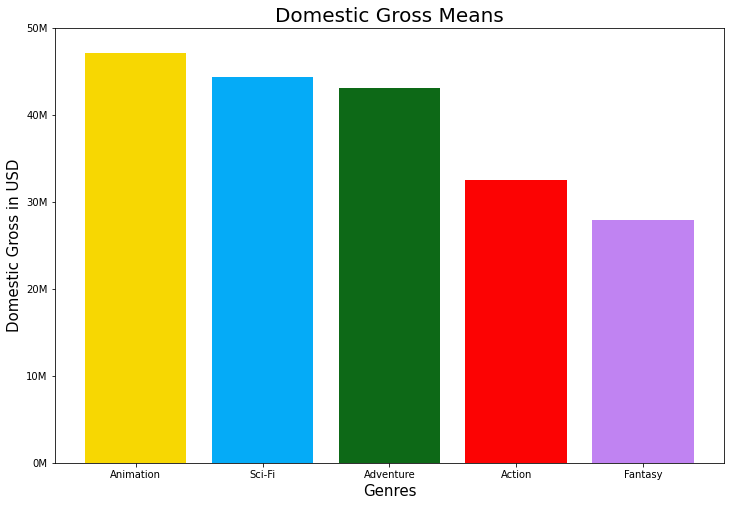

In [26]:
# Bar chart for domestic gross
genres_means_dom = combined_film_df_clean.groupby(['genres'])['domestic_gross'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(genres_means_dom.index[:5], genres_means_dom[:5], color=['#f7d702', '#05abf7', '#0d6917', '#fc0303', '#c083f2'])
ax.set_title('Domestic Gross Means', fontsize=20)
ax.set_xlabel('Genres', fontsize=15)
ax.set_ylabel('Domestic Gross in USD', fontsize=15)
ax.set_yticks(range(0, 60000000, 10000000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter));

### Domestic Return on Investment
The top 5 highest grossing genres in the domestic market are Animation, Sci-Fi, Adventure, Action, and Fantasy. When it comes to return on investment on the other hand, the top 5 genres are completely different than the highest grossing. **The highest returns on investment genres domestically are Mystery, Horror, Thriller, Documentary, and Romance.** While the highest grossing films may generate the most money, they seem to not generate a high return on investment like Mystery and Horror at almost at a **500% return.**

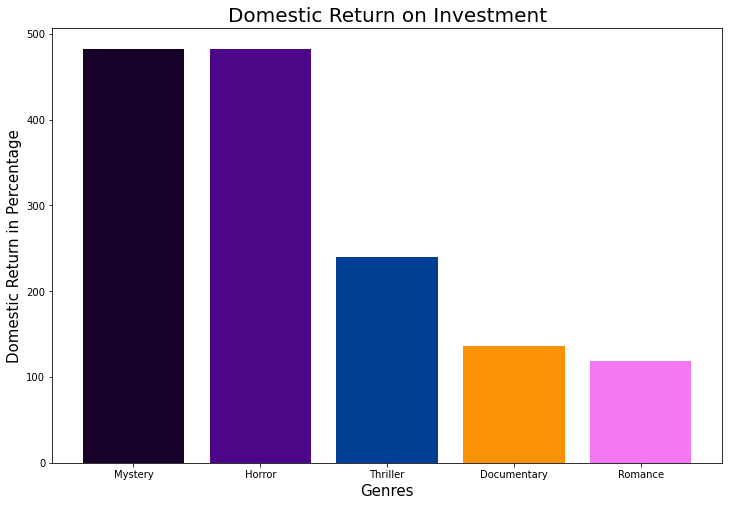

In [27]:
# Bar chart for domestic return on investment
roi_means_dom = combined_film_df_clean.groupby(['genres'])['roi_domestic(%)'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(roi_means_dom.index[:5], roi_means_dom[:5], color=['#180229', '#4b0787', '#013f94', '#fa9107', '#f578f3'])
ax.set_title('Domestic Return on Investment', fontsize=20)
ax.set_xlabel('Genres', fontsize=15)
ax.set_ylabel('Domestic Return in Percentage', fontsize=15);

### Foreign Gross
Just like the highest domestic gross, **the highest foreign gross genres are Animation, Sci-Fi, Adventure, Action, and Fantasy.** Same as in the domestic market, it looks like in the foreign market Animation is still the highest grossing genre at about **110M** on average, with Adventure being the second highest at **100M** just a little higher than Sci-fi which did better domestically.

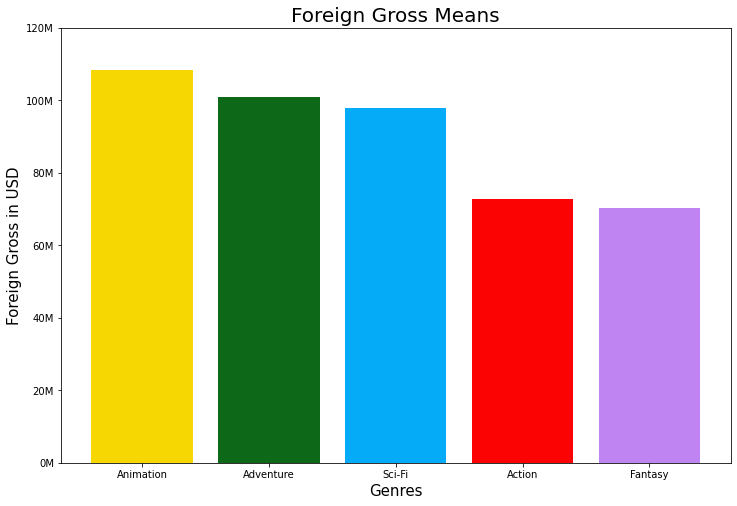

In [28]:
# Bar chart for foreign gross
genres_means_for = combined_film_df_clean.groupby(['genres'])['foreign_gross'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(genres_means_for.index[:5], genres_means_for[:5], color=['#f7d702', '#0d6917', '#05abf7', '#fc0303', '#c083f2'])
ax.set_title('Foreign Gross Means', fontsize=20)
ax.set_xlabel('Genres', fontsize=15)
ax.set_ylabel('Foreign Gross in USD', fontsize=15)
ax.ticklabel_format(style='plain', useOffset=False, axis='y')
ax.set_yticks(range(0, 140000000, 20000000))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter));

### Foreign Return on Investment
For the most part, the foreign RoI chart is very similar to the domestic results. For the foreign RoI, the top 5 genres are **Mystery, Horror, Thriller, Animation, and Sci-fi**. Just like the domestic RoI, mystery is the highest return with almost **800% return average**, and horror comes in second with a little under **750% average return**.

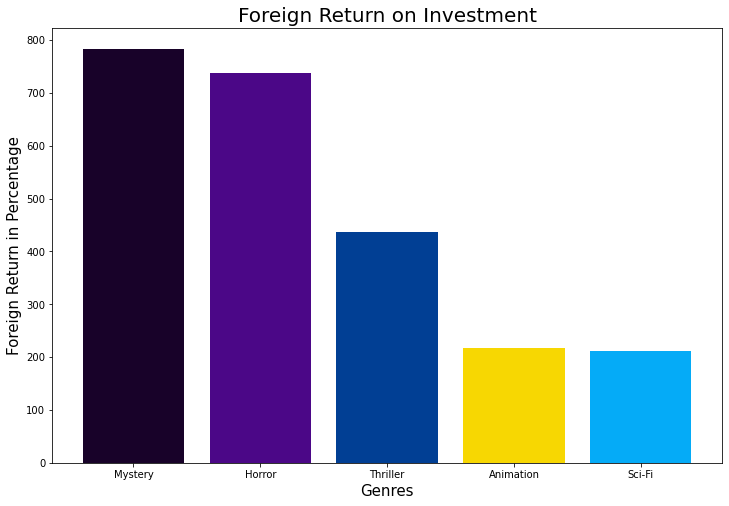

In [29]:
# Bar chart for foreign return on investment
roi_means_for = combined_film_df_clean.groupby(['genres'])['roi_foreign(%)'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(roi_means_for.index[:5], roi_means_for[:5], color=['#180229', '#4b0787', '#013f94', '#f7d702', '#05abf7'])
ax.set_title('Foreign Return on Investment', fontsize=20)
ax.set_xlabel('Genres', fontsize=15)
ax.set_ylabel('Foreign Return in Percentage', fontsize=15);

### Total Return on Investment
In the Total Return on Investment chart, the top 5 genres with highest average return are **Mystery, Horror, Thriller, Romance, and Sci-fi**. Just like the other two RoI charts, both mystery and horror are the top genres. Mystery overall return was nearly a **1400% return**, and horror at **1300% return**. Among the three RoI charts, the results were consistent, especially for the top 3 genres being **Mystery, Horror, and Thriller**.

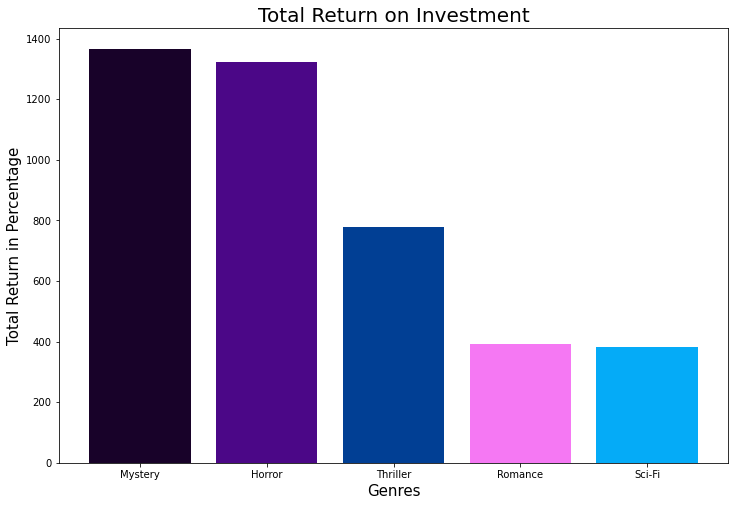

In [30]:
# Bar chart for total return on investment
roi_means_total = combined_film_df_clean.groupby(['genres'])['roi_total(%)'].mean().sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(roi_means_total.index[:5], roi_means_total[:5], color=['#180229', '#4b0787', '#013f94', '#f578f3', '#05abf7'])
ax.set_title('Total Return on Investment', fontsize=20)
ax.set_xlabel('Genres', fontsize=15)
ax.set_ylabel('Total Return in Percentage', fontsize=15);

## Conclusions
Through the analysis of this data, we are able to answer the following questions:
    
**What are the top genres recommended for creating a first film?**

The top 5 genres I would recommend the company look into for a possible first film would be **Mystery, Horror, Thriller, Romance, and Sci-fi, genres.** Overall these 5 genres appear to give the best return in a domestic as well as a foreign market if the company wants to release their film overseas.

**Which genre(s) has the highest return on investment?**

Overall, the one genre that had the highest return on investment is the **Mystery** genre. In the domestic market this genre averaged at nearly a **500% return**. In the foreign market, this genre RoI nearly doubled from a 500% return to an **800% return**.

**Are the top genres consistent throughout both domestic and foreign markets?**

For the most part, the top genres in the domestic and foreign markets are consistent with **Mystery, Horror, and Thriller** being the top three. Spots four and five would change between **Documentary, Romance, Sci-fi, and Animation** in the domestic and foreign markets. Ultimately **Romance, and Sci-fi** made it to the top 5 as overall these two genres had the highest return.

## Limitations
Some limitations with these datasets is that while in the end they do have over 1000 films in common, there was a lot of data that had to be dropped due to simply not having the genre(s) of the film, and by dropping these values there is a possibility of missing out on genres that did extremely well or very poorly that could have changed the outcome. 

Another limitation I found with the data was that some films have the same title, but are made by different studios in foreign countries, so any film(s) that happen to have the same title could have had their values, gross values specifically, changed leading to possible inaccuracies for genres value averages.

## Recommendations
The top 5 genres with the highest return on investment are **Mystery, Horror, Thriller, Romance, and Sci-fi**. Even though the list of genres has been narrowed down to 5 it doesn’t mean instant success in one of those genres. I recommend further research on the recommended genres, specifically on the films that fall under these genres that are considered successful. 

Also, the data sets used for this project included films from around the world. Depending on what the primary market the company's focus is on, I would recommend gathering data for that specific market and running the tests again as there is always the **possibility that a film will do well in one market but fail in a different market.**

## Next Steps
**Further analyzing the data could help in giving a better understanding of the success rate of a genre.** In this project the main focus was narrowing down the genres and this was done by finding the return on investment. Now that we have the top genres, the next steps would be to **narrow the dataset to these specific genres, and research the films listed in these genres.** Finding out what made these films successful or even failures.

With the data narrowed down to the top 5 genres, **we can get a better understanding of how a specific genre has done over a set period.** For example, throughout the data, the **mystery genre didn’t have the highest gross both domestic and foreign, but it did have the highest RoI overall.** Is this result because the genre is becoming popular over the years, or are there a few outlier films that just did very well overall and boosted this genre to the top?

The current data has films that were released between 2010 and 2019, by **running these same tests on data containing films from 2020 to 2025**, it could help in finding the current movie genre trend, and depending on the results of both tests it could help solidify the recommended genre(s).